## Task 1

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import scipy
import scipy.signal

In [29]:
def harmonizeData(period):
    campusdata = pd.read_csv("campusDemand.csv", infer_datetime_format=True)
    
    bdata = campusdata[campusdata["Point name"]=='Baker Hall Electric (Shark 29) - Demand Watts ']
    bdata = pd.DataFrame(index = pd.to_datetime(bdata['Time']), data = bdata['Value'].values, columns=['D'])
    bdata = bdata.resample(period).mean()
    
    tdata = pd.read_csv("temperature.csv", infer_datetime_format=True)
    tdata = pd.DataFrame(index = pd.to_datetime(tdata['Timestamp']), data = tdata['IW.Weather.Kpit56.Csv.Temp'].values, columns=['T'])
    tdata = tdata.resample(period).mean()
    
    df = tdata.merge(bdata, left_on=tdata.index.values, right_on=bdata.index.values).interpolate()
    df = df.set_index("key_0")
    df = df.loc[df.index.dayofweek<5]

    return df
    
df = harmonizeData("15Min")
df.head()

,T,D
key_0,,
2014-02-12 07:00:00,13.645667,75486.107422
2014-02-12 07:15:00,13.353000,174391.348958
2014-02-12 07:30:00,12.848333,184264.052083
2014-02-12 07:45:00,12.212667,189185.911458
2014-02-12 08:00:00,11.806333,190757.645833


## Task 2

In [76]:
def createtempvector(temp):
    temp_b = -10
    temp_t = 90
    if temp <= -10:
        return list(np.concatenate(np.zeros((10))))
    elif temp >= 90:
        return list(10*np.ones(10))
    else:
        num = (temp+10)//10
        rem_value = temp%10

        if num == 9:
            return list(np.concatenate((10*np.ones(9),[rem_value])))
        else:
            return list(np.concatenate((10*np.ones(int(num)), [rem_value], np.zeros((9-int(num))))))

def createtimevector(timearray, time, row_num):
    col_num = time.dayofweek*96+time.hour*4+time.minute//15
    timearray[row_num, col_num] = 1
    return timearray
    
    


In [78]:
def createDesignMatrix1(df):
    templist = []
    timearray = np.zeros((len(df), 480))
    for i in range(len(df)):
        templist.append(createtempvector(df["T"][i]))
        timearray = createtimevector(timearray, df.index[i], i)
        
    templist = np.asarray(templist)
    A = np.concatenate([np.array(templist), np.array(timearray)], axis=1)
    
    return A

A1 = createDesignMatrix1(df)
y = np.asarray(list(df["D"]))

In [79]:
A1.shape, y.shape

((18589, 490), (18589,))

## Task 3

In [81]:
# A1,y = createDesignMatrix1(joined)
coeffs1 = np.dot(np.linalg.pinv(A1),y)
y_hat1 = np.dot(A1,coeffs1)

## Task 4
I am investigating whether or not the 15min intervals are independent of the day.
Thus instead of having a feature for every combination of day and 15min interval, i.e. 480 features ($5days * 24\ hrs * 4 intervals\ per\ hour$), I seperate the two feature and thus have 101 features ($5days + 24\ hrs * 4 intervals\ per\ hour$).

In [83]:
def createtimevector(timearray, time, row_num):
    col_num1 = time.hour*4+time.minute//15
    col_num2 = time.dayofweek+95
    timearray[row_num, col_num1] = 1
    timearray[row_num, col_num2]
    return timearray

In [85]:
def createDesignMatrix2(df):
    templist = []
    timearray = np.zeros((len(df), 101))
    for i in range(len(df)):
        templist.append(createtempvector(df["T"][i]))
        timearray = createtimevector(timearray, df.index[i], i)
        
    templist = np.asarray(templist)
    A = np.concatenate([np.array(templist), np.array(timearray)], axis=1)
    
    return A

A2 = createDesignMatrix2(df)
coeffs2 = np.dot(np.linalg.pinv(A2),y)
y_hat2 = np.dot(A2,coeffs2)

## Task 5

Text(0,0.5,'Variant [kW]')

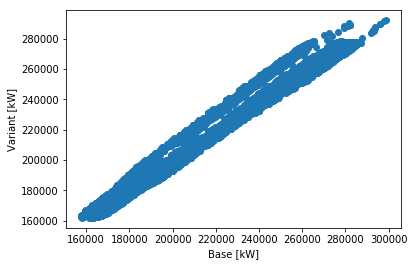

In [86]:
plt.figure()
plt.scatter(y_hat1, y_hat2)
plt.xlabel('Base [kW]')
plt.ylabel('Variant [kW]')

## Task 6

{'boxes': [<matplotlib.lines.Line2D at 0x1c50a98fef0>,
 'caps': [<matplotlib.lines.Line2D at 0x1c50a998940>,
 'fliers': [<matplotlib.lines.Line2D at 0x1c50a9a15f8>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1c50a9a11d0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x1c50a998080>,
  <matplotlib.lines.Line2D at 0x1c50a9a82b0>]}

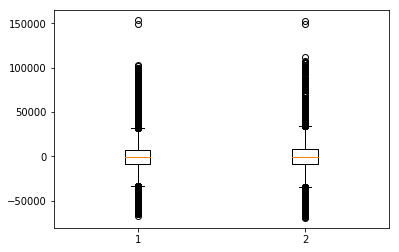

In [87]:
plt.figure()
plt.boxplot([(y_hat1-y), (y_hat2-y)])

## Task 7

I am using Budeanu's definition of reactive power.

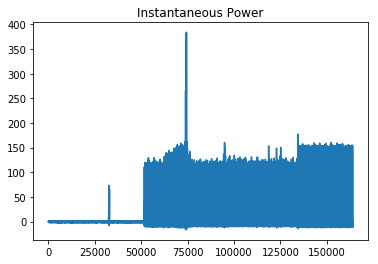

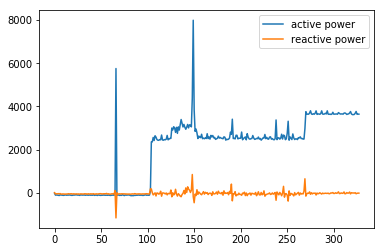

In [129]:
def computePQ(cur, volt):
    low = 0
    
    volt = np.convolve(volt, np.ones((5,))/5, mode="same")
    cur = np.convolve(cur, np.ones((5,))/5, mode="same")
    instant_power = cur*volt
    counter=0
    lower=0
    allpowers = []
    for i in range(len(volt)-1):
        if volt[i]<0 and volt[i]*volt[i+1]<=0:
            
            power = cur[low:i]*volt[low:i]
            subs = np.min([len(power), 500])
            power_ele = np.zeros((500))
            power_ele[:subs] = power[:subs]
            allpowers.append(power_ele)
            low = i
    values = np.fft.fft(allpowers)
#     print(values[0,:1])
    plt.figure()
    plt.title('Instantaneous Power')
    plt.plot(instant_power)
    plt.figure()
    plt.plot(np.mean(np.real(values[:,:2]),axis=1), label='active power')
    plt.plot(np.mean(np.imag(values[:,:2]),axis=1), label='reactive power')
    plt.plot(xlabel='cycles')
    plt.legend()

    
data = np.loadtxt('116.csv', delimiter=',')
computePQ(data[:,0],data[:,1])